In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display
from tqdm import tqdm
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras.models as models
import tensorflow.keras.layers as layers

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

CSV_FILE_PATH = "./esc50.csv"  # path of csv file
DATA_PATH = "./audio/audio/44100/" # path to folde

df = pd.read_csv(CSV_FILE_PATH)
df


,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A
...,...,...,...,...,...,...,...
1995,5-263831-B-6.wav,5,6,hen,False,263831,B
1996,5-263902-A-36.wav,5,36,vacuum_cleaner,False,263902,A
1997,5-51149-A-25.wav,5,25,footsteps,False,51149,A
1998,5-61635-A-8.wav,5,8,sheep,False,61635,A


In [9]:
df_10 = df[df['esc10']==True]
df_10 = df_10.drop(['fold','esc10','src_file','take'], axis=1)
df_10


classes = df_10['category'].unique()
classes

class_dict = {i:x for x,i in enumerate(classes)}
class_dict

df_10['target'] = df_10['category'].map(class_dict)
df_10

sample_df = df_10.drop_duplicates(subset=['target'])
sample_df


,filename,target,category
0,1-100032-A-0.wav,0,dog
14,1-110389-A-0.wav,0,dog
24,1-116765-A-41.wav,41,chainsaw
54,1-17150-A-12.wav,12,crackling_fire
55,1-172649-A-40.wav,40,helicopter
...,...,...,...
1876,5-233160-A-1.wav,1,rooster
1888,5-234879-A-1.wav,1,rooster
1889,5-234879-B-1.wav,1,rooster
1894,5-235671-A-38.wav,38,clock_tick


array(['dog', 'chainsaw', 'crackling_fire', 'helicopter', 'rain',
       'crying_baby', 'clock_tick', 'sneezing', 'rooster', 'sea_waves'],
      dtype=object)

{'dog': 0,
 'chainsaw': 1,
 'crackling_fire': 2,
 'helicopter': 3,
 'rain': 4,
 'crying_baby': 5,
 'clock_tick': 6,
 'sneezing': 7,
 'rooster': 8,
 'sea_waves': 9}

,filename,target,category
0,1-100032-A-0.wav,0,dog
14,1-110389-A-0.wav,0,dog
24,1-116765-A-41.wav,1,chainsaw
54,1-17150-A-12.wav,2,crackling_fire
55,1-172649-A-40.wav,3,helicopter
...,...,...,...
1876,5-233160-A-1.wav,8,rooster
1888,5-234879-A-1.wav,8,rooster
1889,5-234879-B-1.wav,8,rooster
1894,5-235671-A-38.wav,6,clock_tick


,filename,target,category
0,1-100032-A-0.wav,0,dog
24,1-116765-A-41.wav,1,chainsaw
54,1-17150-A-12.wav,2,crackling_fire
55,1-172649-A-40.wav,3,helicopter
62,1-17367-A-10.wav,4,rain
78,1-187207-A-20.wav,5,crying_baby
110,1-21934-A-38.wav,6,clock_tick
136,1-26143-A-21.wav,7,sneezing
141,1-26806-A-1.wav,8,rooster
148,1-28135-A-11.wav,9,sea_waves


0it [00:00, ?it/s]

22050

1it [00:00,  6.14it/s]

22050

2it [00:00,  6.19it/s]

22050

3it [00:00,  6.27it/s]

22050

4it [00:00,  6.39it/s]

22050

5it [00:00,  6.41it/s]

22050

6it [00:00,  6.52it/s]

22050

7it [00:01,  6.48it/s]

22050

8it [00:01,  6.30it/s]

22050

9it [00:01,  6.39it/s]

22050

10it [00:01,  6.45it/s]


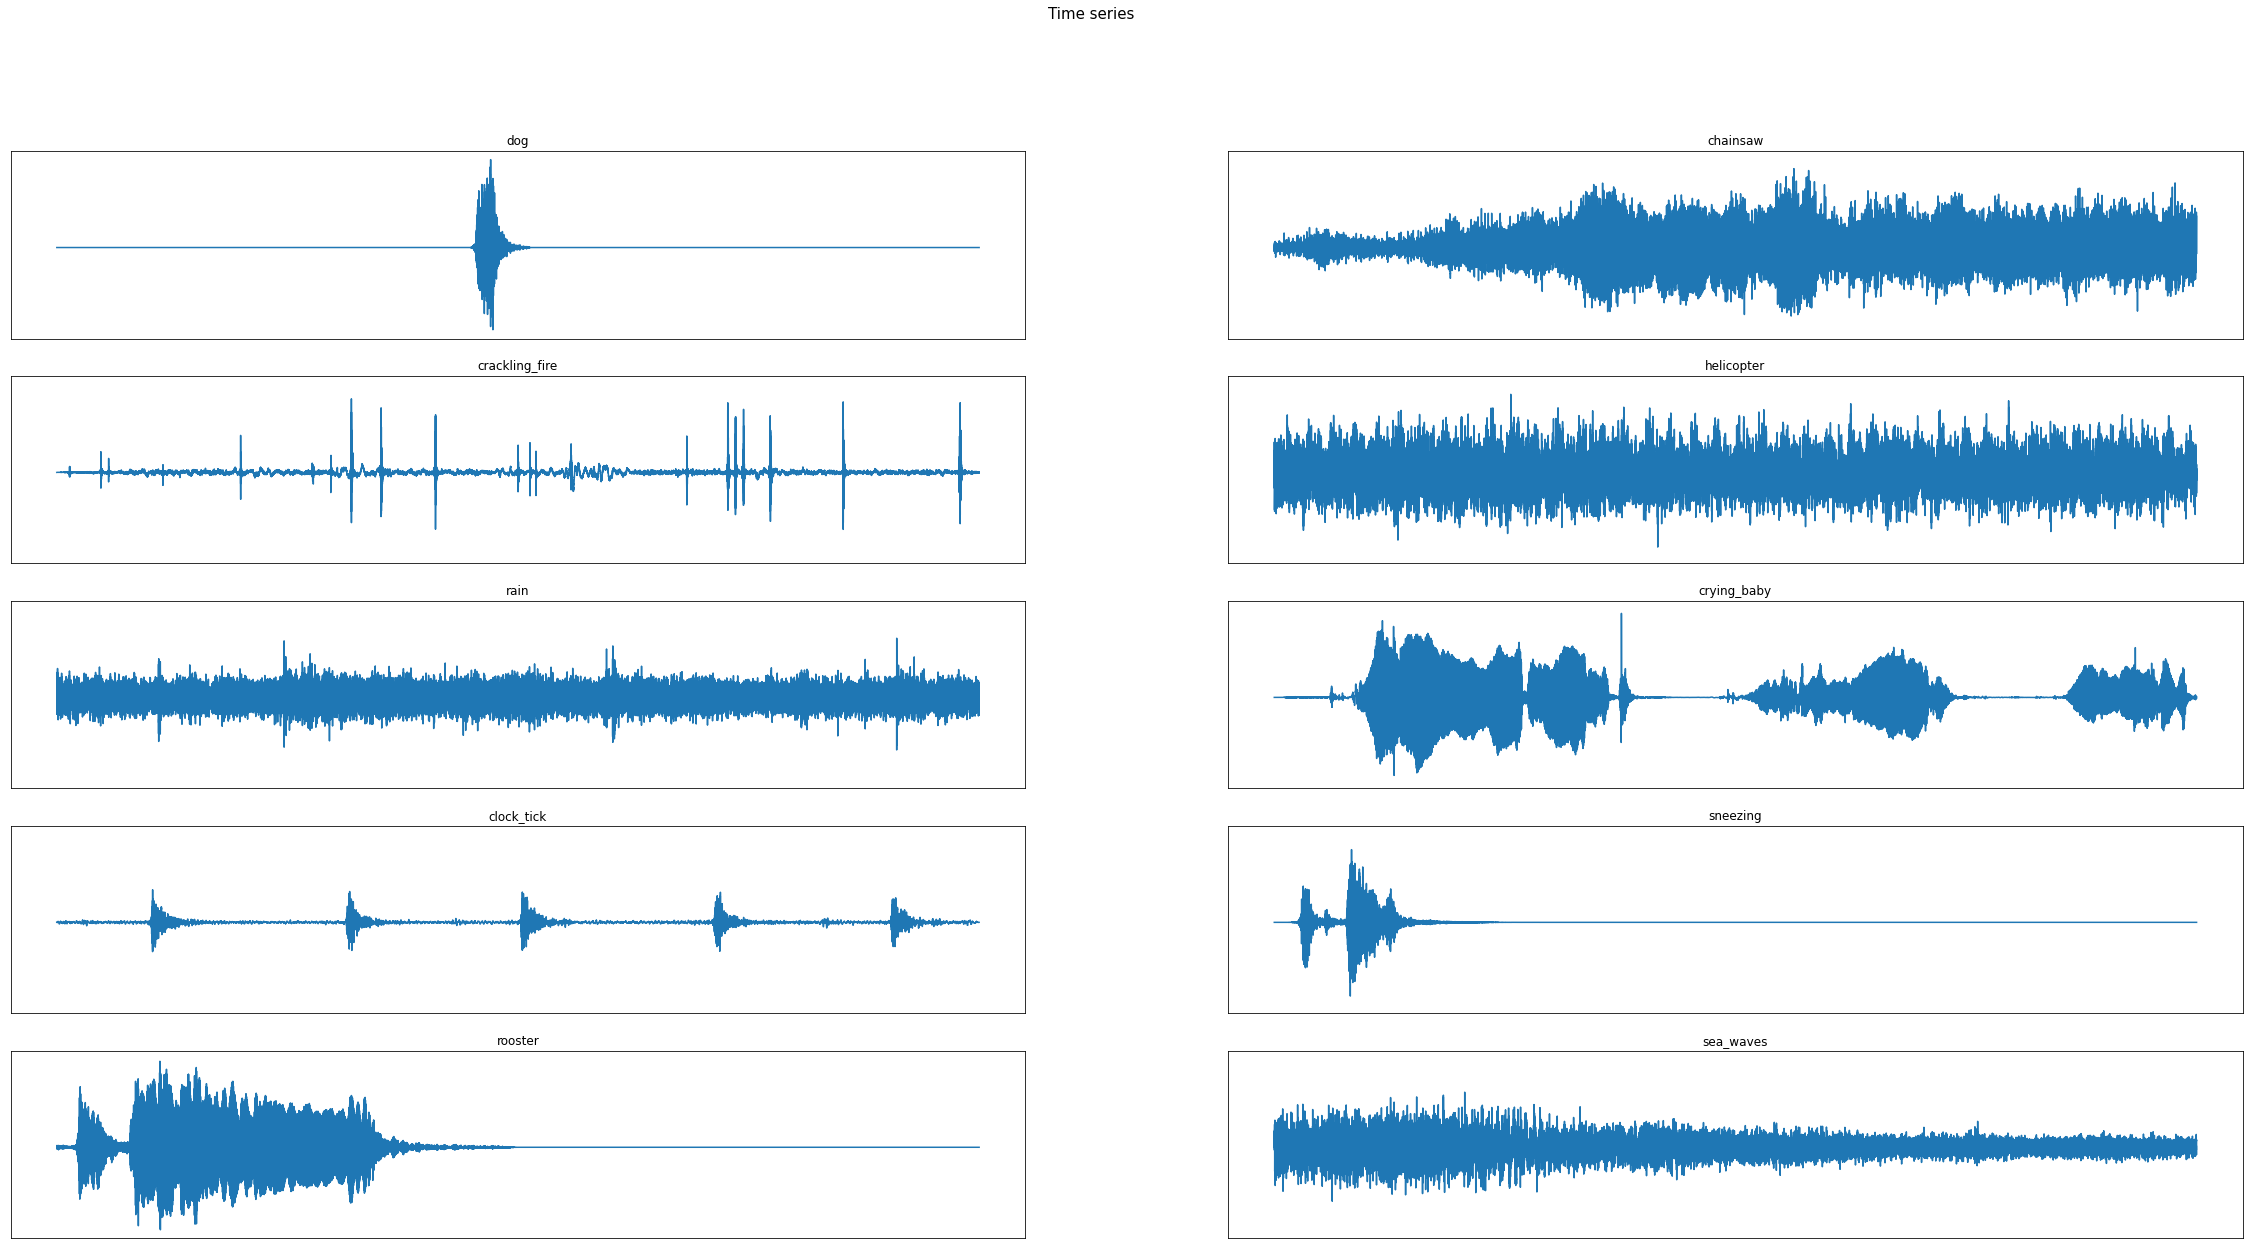

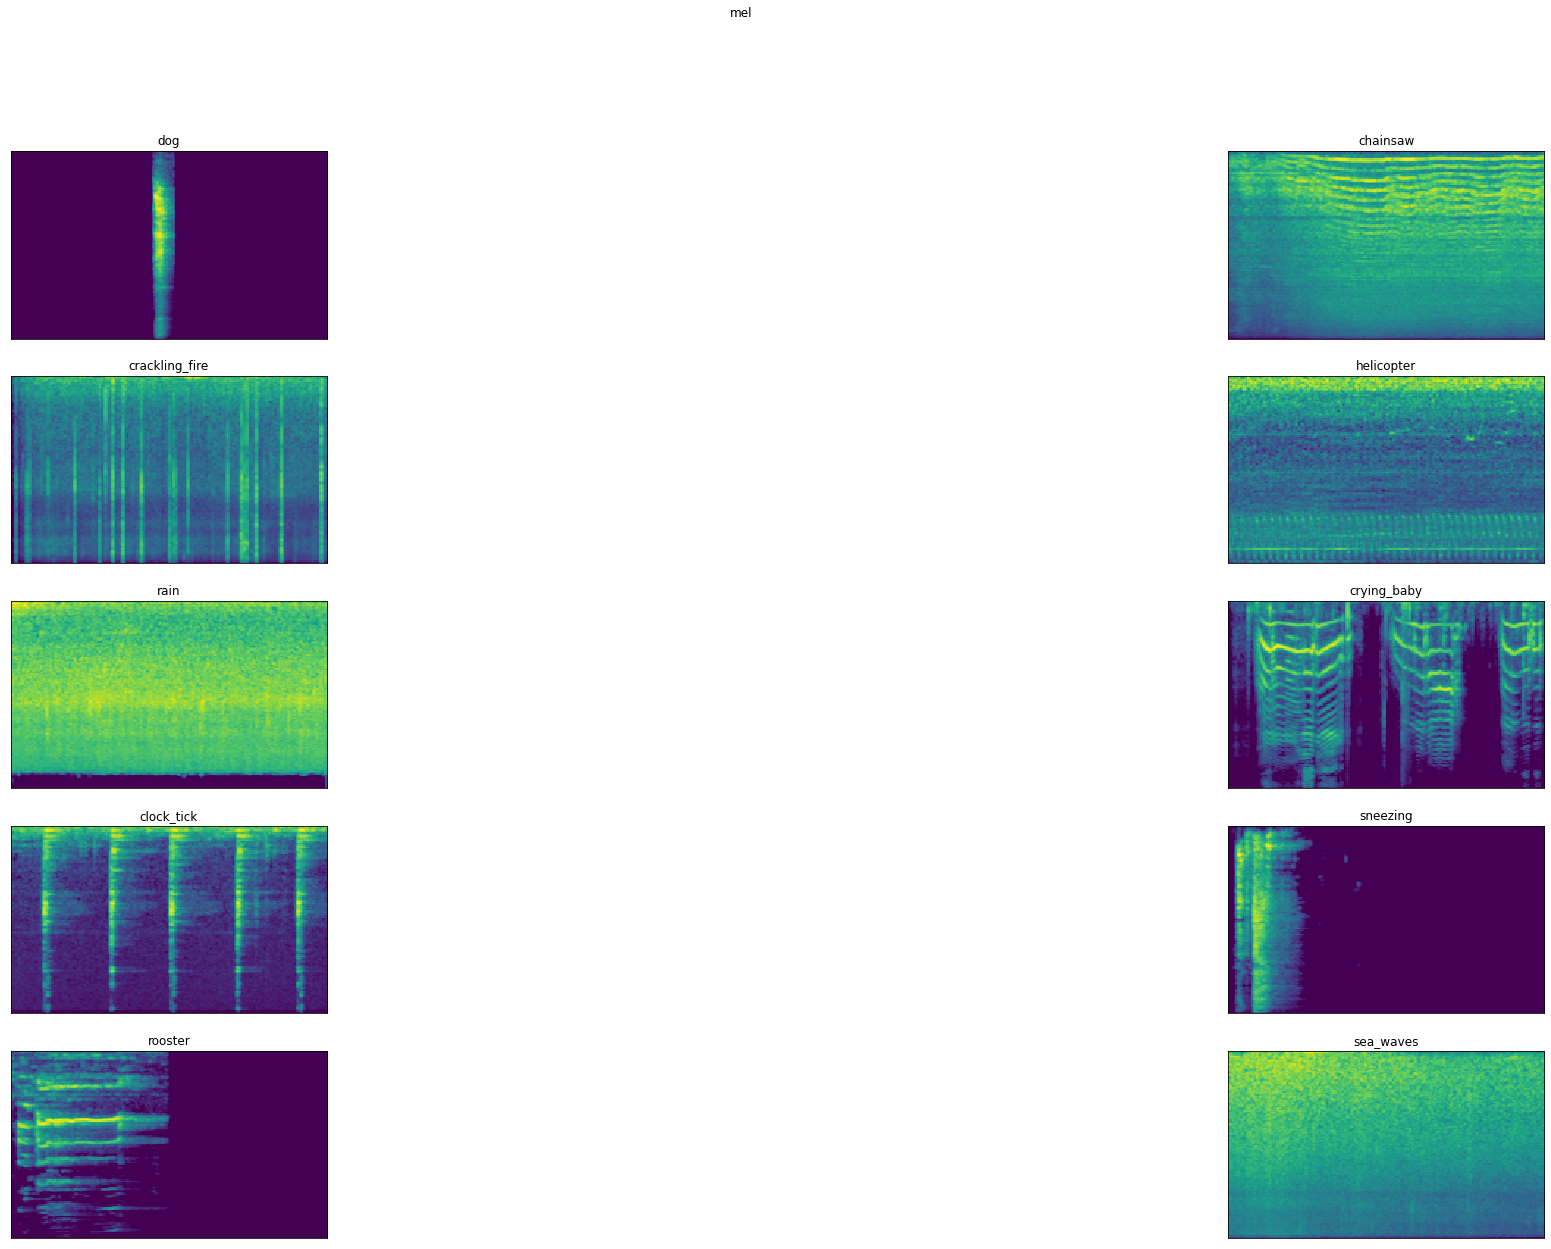

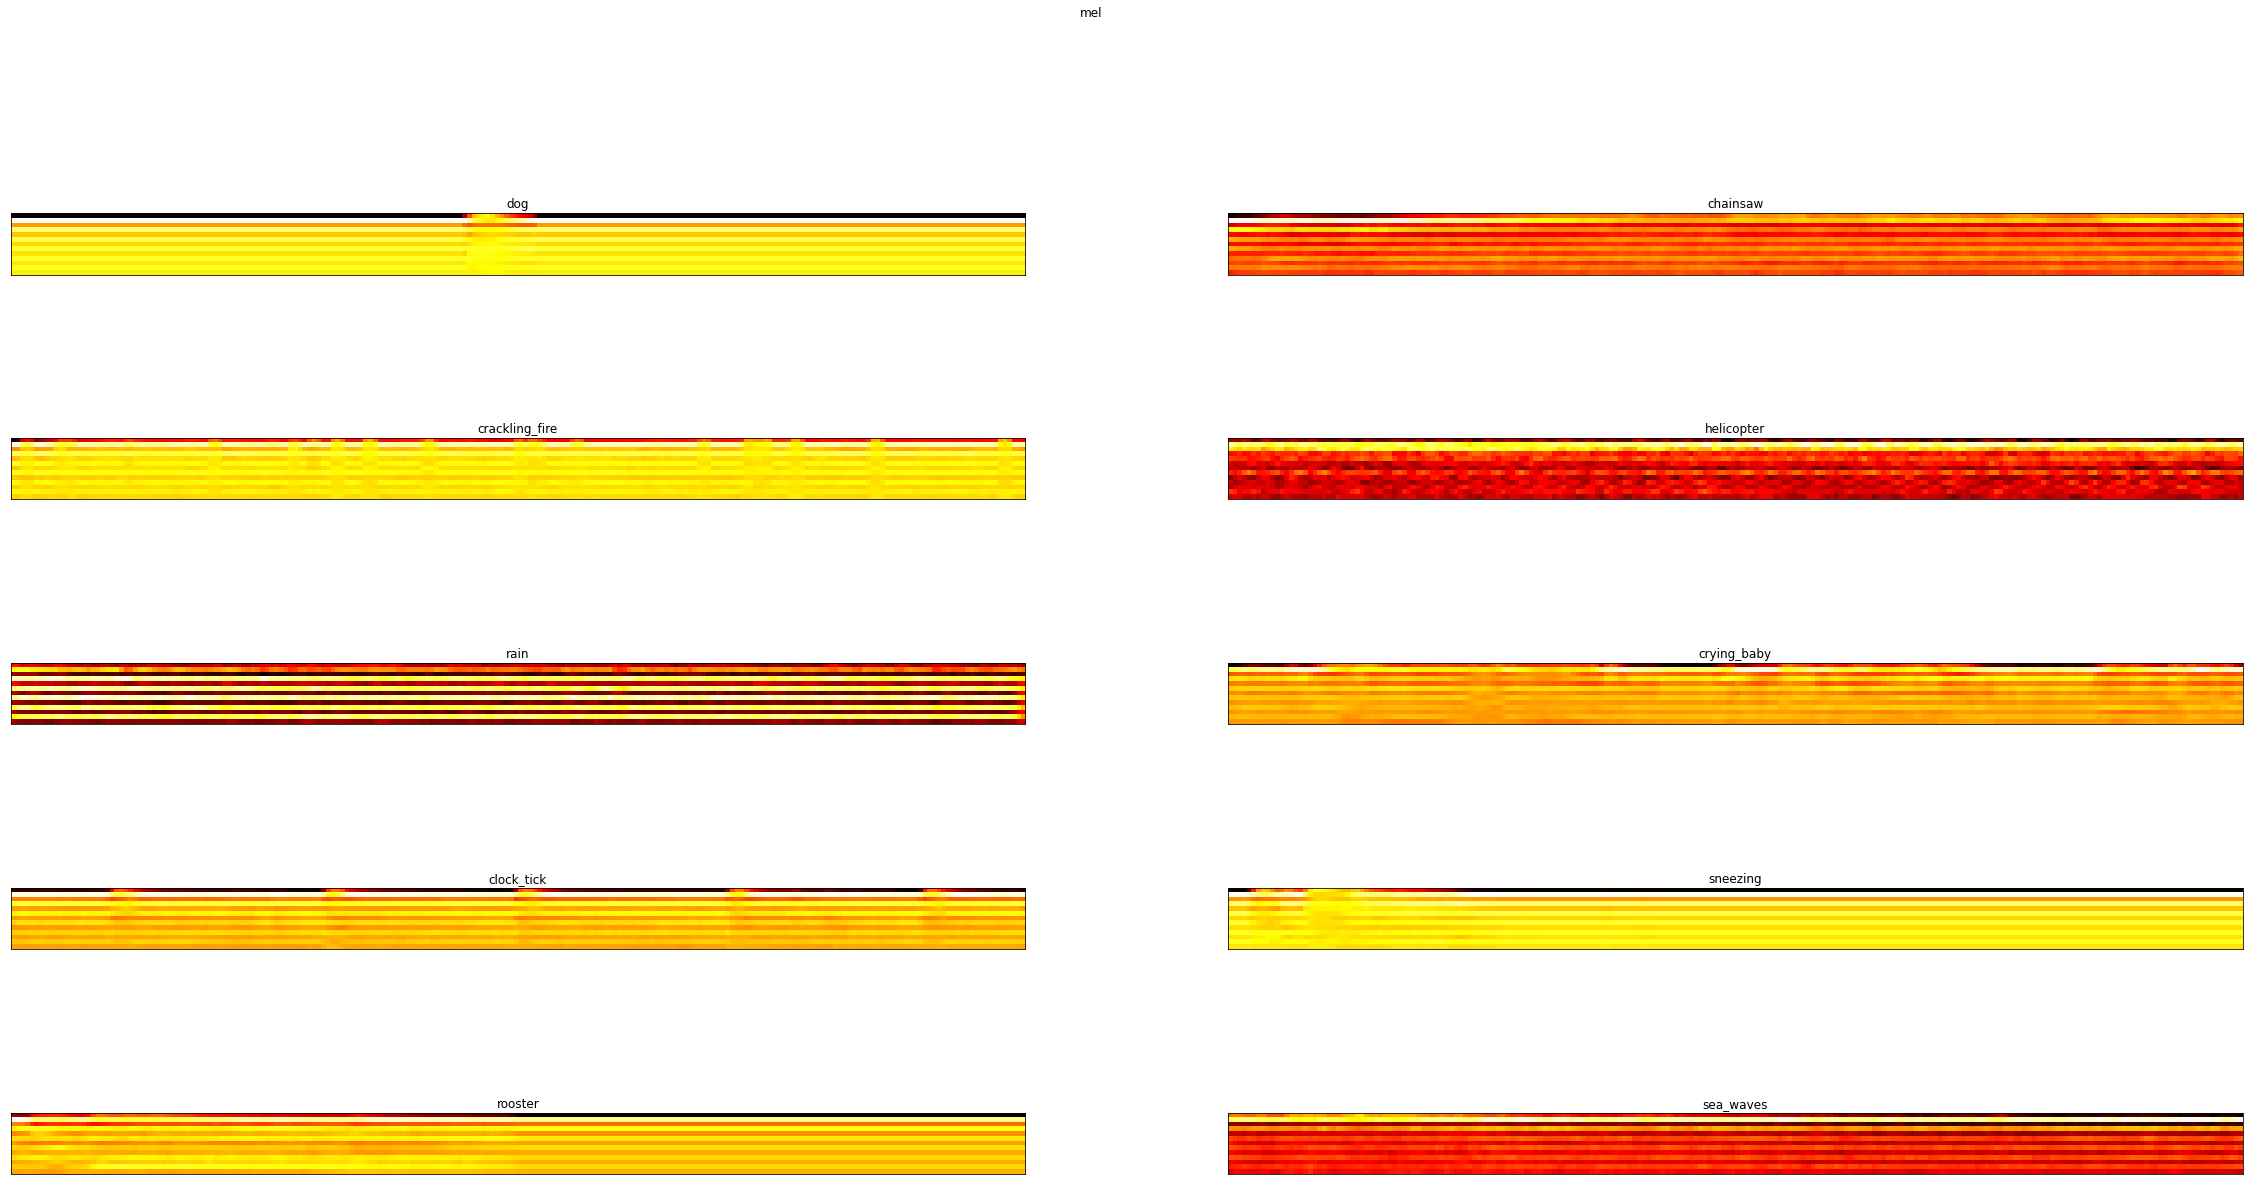

In [10]:
signals = {}
mel_spectrograms = {}
mfccs = {}

for row in tqdm(sample_df.iterrows()):  # every row will be like [[index], [filename , target , category]]
    signal , rate = librosa.load(DATA_PATH+ row[1][0])
    signals[row[1][2]] = signal    # row[1][2] will be the category of that signal. eg. signal["dog"] = signal of dog sound
    rate
    
    mel_spec = librosa.feature.melspectrogram(y=signal , sr=rate ,  n_fft=2048, hop_length=512)
    mel_spec = librosa.power_to_db(mel_spec, ref=np.max)  #visualizing mel_spectrogram directly gives black image. So, coverting from power_to_db is required
    mel_spectrograms[row[1][2]] = mel_spec
    
    mfcc = librosa.feature.mfcc(signal , rate , n_mfcc=13, dct_type=3)
    mfccs[row[1][2]] = mfcc
    
def dis_feature(mfccs, cmap=None):
    """
    this function will take the mfcc/mel_spectrogram dictionary and plot the signals
    """
    fig ,axes= plt.subplots(nrows=5 , ncols=2 , sharex=False, sharey=True , figsize=(40,20))
    fig.suptitle('mel')
    i=0
    for x in range(5):
        for y in range(2):
            axes[x,y].set_title(list(mfccs.keys())[i])
            axes[x,y].imshow(list(mfccs.values())[i], cmap=cmap,interpolation='nearest')
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i+=1
            
def plot_signal(signal):
    """
    this function will take the signal dictionary and plot the signals
    """
    fig , axes = plt.subplots(nrows=5 , ncols=2 , sharex =False ,sharey=True,
                             figsize=(40,20))
    fig.suptitle('Time series',size=15)
    i=0
    for x in range(5):
        for y in range(2):
            axes[x,y].set_title(list(signal.keys())[i])
            axes[x,y].plot(list(signal.values())[i])
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i +=1

plot_signal(signals)
dis_feature(mel_spectrograms)
dis_feature(mfccs, cmap='hot')


In [8]:
X , y = [] , []
for data in tqdm(df_10.iterrows()):
  data  
  sig , sr = librosa.load(DATA_PATH+data[1][0])
  sr
  for i in range(3):
    n = np.random.randint(0, len(sig)-(sr*2))
    sig_ = sig[n : int(n+(sr*2))]
    mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
    X.append(mfcc_)
    y.append(data[1][1])

# convert list to numpy array
X = np.array(X) 
y = np.array(y)

#one-hot encoding the target
y = tf.keras.utils.to_categorical(y , num_classes=10)

# our tensorflow model takes input as (no_of_sample , height , width , channel).
# here X has dimension (no_of_sample , height , width).
# So, the below code will reshape it to (no_of_sample , height , width , 1).
X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)


0it [00:00, ?it/s]

(0,
 filename    1-100032-A-0.wav
 target                     0
 category                 dog
 Name: 0, dtype: object)

22050

1it [00:00,  5.31it/s]

(14,
 filename    1-110389-A-0.wav
 target                     0
 category                 dog
 Name: 14, dtype: object)

22050

2it [00:00,  5.62it/s]

(24,
 filename    1-116765-A-41.wav
 target                      1
 category             chainsaw
 Name: 24, dtype: object)

22050

3it [00:00,  5.85it/s]

(54,
 filename    1-17150-A-12.wav
 target                     2
 category      crackling_fire
 Name: 54, dtype: object)

22050

4it [00:00,  6.05it/s]

(55,
 filename    1-172649-A-40.wav
 target                      3
 category           helicopter
 Name: 55, dtype: object)

22050

5it [00:00,  6.20it/s]

(56,
 filename    1-172649-B-40.wav
 target                      3
 category           helicopter
 Name: 56, dtype: object)

22050

6it [00:00,  6.33it/s]

(57,
 filename    1-172649-C-40.wav
 target                      3
 category           helicopter
 Name: 57, dtype: object)

22050

7it [00:01,  6.40it/s]

(58,
 filename    1-172649-D-40.wav
 target                      3
 category           helicopter
 Name: 58, dtype: object)

22050

8it [00:01,  6.46it/s]

(59,
 filename    1-172649-E-40.wav
 target                      3
 category           helicopter
 Name: 59, dtype: object)

22050

9it [00:01,  6.56it/s]

(60,
 filename    1-172649-F-40.wav
 target                      3
 category           helicopter
 Name: 60, dtype: object)

22050

10it [00:01,  6.57it/s]

(62,
 filename    1-17367-A-10.wav
 target                     4
 category                rain
 Name: 62, dtype: object)

22050

11it [00:01,  6.59it/s]

(63,
 filename    1-17565-A-12.wav
 target                     2
 category      crackling_fire
 Name: 63, dtype: object)

22050

12it [00:01,  6.59it/s]

(65,
 filename    1-17742-A-12.wav
 target                     2
 category      crackling_fire
 Name: 65, dtype: object)

22050

13it [00:02,  6.59it/s]

(66,
 filename    1-17808-A-12.wav
 target                     2
 category      crackling_fire
 Name: 66, dtype: object)

22050

14it [00:02,  6.60it/s]

(67,
 filename    1-17808-B-12.wav
 target                     2
 category      crackling_fire
 Name: 67, dtype: object)

22050

15it [00:02,  6.60it/s]

(72,
 filename    1-181071-A-40.wav
 target                      3
 category           helicopter
 Name: 72, dtype: object)

22050

16it [00:02,  6.64it/s]

(73,
 filename    1-181071-B-40.wav
 target                      3
 category           helicopter
 Name: 73, dtype: object)

22050

17it [00:02,  6.61it/s]

(78,
 filename    1-187207-A-20.wav
 target                      5
 category          crying_baby
 Name: 78, dtype: object)

22050

18it [00:02,  6.40it/s]

(92,
 filename    1-19898-A-41.wav
 target                     1
 category            chainsaw
 Name: 92, dtype: object)

22050

19it [00:02,  6.28it/s]

(93,
 filename    1-19898-B-41.wav
 target                     1
 category            chainsaw
 Name: 93, dtype: object)

22050

20it [00:03,  6.38it/s]

(94,
 filename    1-19898-C-41.wav
 target                     1
 category            chainsaw
 Name: 94, dtype: object)

22050

21it [00:03,  6.25it/s]

(104,
 filename    1-211527-A-20.wav
 target                      5
 category          crying_baby
 Name: 104, dtype: object)

22050

22it [00:03,  6.11it/s]

(105,
 filename    1-211527-B-20.wav
 target                      5
 category          crying_baby
 Name: 105, dtype: object)

22050

23it [00:03,  6.25it/s]

(106,
 filename    1-211527-C-20.wav
 target                      5
 category          crying_baby
 Name: 106, dtype: object)

22050

24it [00:03,  6.41it/s]

(107,
 filename    1-21189-A-10.wav
 target                     4
 category                rain
 Name: 107, dtype: object)

22050

25it [00:03,  6.58it/s]

(110,
 filename    1-21934-A-38.wav
 target                     6
 category          clock_tick
 Name: 110, dtype: object)

22050

26it [00:04,  6.33it/s]

(111,
 filename    1-21935-A-38.wav
 target                     6
 category          clock_tick
 Name: 111, dtype: object)

22050

27it [00:04,  6.44it/s]

(113,
 filename    1-22694-A-20.wav
 target                     5
 category         crying_baby
 Name: 113, dtype: object)

22050

28it [00:04,  6.50it/s]

(114,
 filename    1-22694-B-20.wav
 target                     5
 category         crying_baby
 Name: 114, dtype: object)

22050

29it [00:04,  6.32it/s]

(136,
 filename    1-26143-A-21.wav
 target                     7
 category            sneezing
 Name: 136, dtype: object)

22050

30it [00:04,  6.46it/s]

(140,
 filename    1-26222-A-10.wav
 target                     4
 category                rain
 Name: 140, dtype: object)

22050

31it [00:04,  6.50it/s]

(141,
 filename    1-26806-A-1.wav
 target                    8
 category            rooster
 Name: 141, dtype: object)

22050

32it [00:04,  6.55it/s]

(146,
 filename    1-27724-A-1.wav
 target                    8
 category            rooster
 Name: 146, dtype: object)

22050

33it [00:05,  6.61it/s]

(148,
 filename    1-28135-A-11.wav
 target                     9
 category           sea_waves
 Name: 148, dtype: object)

22050

33it [00:05,  6.27it/s]


KeyboardInterrupt: 

In [5]:
X.shape
y.shape

x_train , x_val , y_train , y_val = train_test_split(X , y ,test_size=0.2, random_state=2020)

INPUTSHAPE = (13,87,1)

model =  models.Sequential([
                          layers.Conv2D(16 , (3,3),activation = 'relu',padding='valid', input_shape = INPUTSHAPE),
                          layers.Conv2D(16, (3,3), activation='relu',padding='valid'),

                          layers.Conv2D(32, (3,3), activation='relu',padding='valid'),
                          layers.Conv2D(32, (3,3), activation='relu',padding='valid'),

                          layers.Conv2D(64, (3,3), activation='relu',padding='valid'),
                          layers.Conv2D(32, (3,3), activation='relu',padding='valid'),
                          layers.GlobalAveragePooling2D(),


                          layers.Dense(32 , activation = 'relu'),
                          layers.Dense(10 , activation = 'softmax')
])

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = 'acc')

model.summary()


(1200, 13, 87, 1)

(1200, 10)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 11, 85, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 9, 83, 16)         2320      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 81, 32)         4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 79, 32)         9248      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 77, 64)         18496     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 75, 32)         18464     
_________________________________________________________________
global_average_pooling2d (Gl (None, 32)                0

In [6]:
LOGDIR = "logs"
CPKT = "cpkt/"

#this callback is used to prevent overfitting.
callback_1 = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto',
    baseline=None, restore_best_weights=False
)

#this checkpoint saves the best weights of model at every epoch
callback_2 = tf.keras.callbacks.ModelCheckpoint(
    CPKT, monitor='val_loss', verbose=0, save_best_only=True,
    save_weights_only=True, mode='auto', save_freq='epoch', options=None
)

#this is for tensorboard
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=LOGDIR)


history = model.fit(x_train,y_train ,
            validation_data=(x_val,y_val),
            epochs=100)


Epoch 1/100
30/30 [==============================] - 1s 48ms/step - loss: 2.0332 - acc: 0.2323 - val_loss: 1.8155 - val_acc: 0.3208
Epoch 2/100
30/30 [==============================] - 1s 45ms/step - loss: 1.5044 - acc: 0.4688 - val_loss: 1.2060 - val_acc: 0.6000
Epoch 3/100
30/30 [==============================] - 1s 46ms/step - loss: 1.1147 - acc: 0.6083 - val_loss: 1.0004 - val_acc: 0.6167
Epoch 4/100
30/30 [==============================] - 1s 47ms/step - loss: 0.8053 - acc: 0.7042 - val_loss: 0.9996 - val_acc: 0.6750
Epoch 5/100
30/30 [==============================] - 1s 47ms/step - loss: 0.8060 - acc: 0.7146 - val_loss: 0.9558 - val_acc: 0.6625
Epoch 6/100
30/30 [==============================] - 1s 47ms/step - loss: 0.7485 - acc: 0.7302 - val_loss: 0.8403 - val_acc: 0.6958
Epoch 7/100
30/30 [==============================] - 1s 46ms/step - loss: 0.6330 - acc: 0.7781 - val_loss: 0.7891 - val_acc: 0.7500
Epoch 8/100
30/30 [==============================] - 1s 47ms/step - loss: 0.

KeyboardInterrupt: 